In [22]:
# Stock Volume Predictor

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppressing TF warnings

import random
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [2]:
random.seed(1693)
np.random.seed(1693)
tf.random.set_seed(1693)

In [3]:
# Loading & Preping Dataframes
cols = ['DJ_return', 'log_volume', 'log_volatility']

file_path = r'C:\Users\sunet\OneDrive\Desktop\AI and ML Projects\Stock Prediction\NYSE.csv'
data = pd.read_csv(file_path)

In [4]:
# Standardize data
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(data[cols]), columns=cols)

print("0. the shape of dataframe X: ", X.shape)
print("1. the first record of dataframe X: ", X.iloc[0])

0. the shape of dataframe X:  (6051, 3)
1. the first record of dataframe X:  DJ_return        -0.549823
log_volume        0.175075
log_volatility   -4.357078
Name: 0, dtype: float64


In [6]:
# Creating lagged versions of the data
num_lags = 5
for i in range(1, num_lags + 1):
    X[f'DJ_return_lag_{i}'] = X['DJ_return'].shift(i)
    X[f'log_volume_lag_{i}'] = X['log_volume'].shift(i)
    X[f'log_volatility_lag_{i}'] = X['log_volatility'].shift(i)

X['train'] = data['train']
print("2. the shape of dataframe X with lags: ", X.shape)
print("3. the first record of the data frame with lags: ", X.iloc[0])


2. the shape of dataframe X with lags:  (6051, 19)
3. the first record of the data frame with lags:  DJ_return              -0.549823
log_volume              0.175075
log_volatility         -4.357078
DJ_return_lag_1              NaN
log_volume_lag_1             NaN
log_volatility_lag_1         NaN
DJ_return_lag_2              NaN
log_volume_lag_2             NaN
log_volatility_lag_2         NaN
DJ_return_lag_3              NaN
log_volume_lag_3             NaN
log_volatility_lag_3         NaN
DJ_return_lag_4              NaN
log_volume_lag_4             NaN
log_volatility_lag_4         NaN
DJ_return_lag_5              NaN
log_volume_lag_5             NaN
log_volatility_lag_5         NaN
train                       True
Name: 0, dtype: object


In [7]:
# Dropping missing values
X.dropna(inplace=True)
print("4. the shape of dataframe X with lags: ", X.shape)
print("5. the first record of dataframe X with lags: ", X.iloc[0])

4. the shape of dataframe X with lags:  (6046, 19)
5. the first record of dataframe X with lags:  DJ_return              -1.304126
log_volume              0.605918
log_volatility         -1.366028
DJ_return_lag_1          0.04634
log_volume_lag_1        0.224779
log_volatility_lag_1    -2.50097
DJ_return_lag_2        -0.431397
log_volume_lag_2        0.935176
log_volatility_lag_2   -2.366521
DJ_return_lag_3         0.434813
log_volume_lag_3        2.283789
log_volatility_lag_3   -2.418037
DJ_return_lag_4           0.9052
log_volume_lag_4        1.517291
log_volatility_lag_4   -2.529058
DJ_return_lag_5        -0.549823
log_volume_lag_5        0.175075
log_volatility_lag_5   -4.357078
train                       True
Name: 5, dtype: object


In [8]:
# Separating target and train/test indicator
Y = X['log_volume']
train = X['train']
X.drop(['DJ_return', 'log_volume', 'log_volatility', 'train'], axis=1, inplace=True)

In [9]:
print("6. the first 3 records of the Y target: ", Y.head(3).values)
print("7. the first 3 records of the train variable: ", train.head(3).values)
print("8. the first 3 records of dataframe X: ", X.head(3).values)

6. the first 3 records of the Y target:  [ 0.60591805 -0.01366095  0.04255198]
7. the first 3 records of the train variable:  [ True  True  True]
8. the first 3 records of dataframe X:  [[ 0.04634026  0.22477858 -2.5009701  -0.43139673  0.93517558 -2.36652094
   0.43481275  2.28378937 -2.41803694  0.90519995  1.51729071 -2.52905765
  -0.54982334  0.17507497 -4.35707786]
 [-1.30412619  0.60591805 -1.366028    0.04634026  0.22477858 -2.5009701
  -0.43139673  0.93517558 -2.36652094  0.43481275  2.28378937 -2.41803694
   0.90519995  1.51729071 -2.52905765]
 [-0.00629379 -0.01366095 -1.50566722 -1.30412619  0.60591805 -1.366028
   0.04634026  0.22477858 -2.5009701  -0.43139673  0.93517558 -2.36652094
   0.43481275  2.28378937 -2.41803694]]


In [10]:
# Reindexing and reshaping
X = X.reindex(columns=[
    f'{col}_lag_{i}' for i in range(1, num_lags + 1) for col in ['DJ_return', 'log_volume', 'log_volatility']
])
print("9. the first 3 records of X after reindexing: ", X.head(3).values)

# Reshape for RNN
X = X.values.reshape(-1, num_lags, len(cols))
print("10. the shape of X after reshaping: ", X.shape)
print("11. the first 2 records of X after reshaping: ", X[:2])

9. the first 3 records of X after reindexing:  [[ 0.04634026  0.22477858 -2.5009701  -0.43139673  0.93517558 -2.36652094
   0.43481275  2.28378937 -2.41803694  0.90519995  1.51729071 -2.52905765
  -0.54982334  0.17507497 -4.35707786]
 [-1.30412619  0.60591805 -1.366028    0.04634026  0.22477858 -2.5009701
  -0.43139673  0.93517558 -2.36652094  0.43481275  2.28378937 -2.41803694
   0.90519995  1.51729071 -2.52905765]
 [-0.00629379 -0.01366095 -1.50566722 -1.30412619  0.60591805 -1.366028
   0.04634026  0.22477858 -2.5009701  -0.43139673  0.93517558 -2.36652094
   0.43481275  2.28378937 -2.41803694]]
10. the shape of X after reshaping:  (6046, 5, 3)
11. the first 2 records of X after reshaping:  [[[ 0.04634026  0.22477858 -2.5009701 ]
  [-0.43139673  0.93517558 -2.36652094]
  [ 0.43481275  2.28378937 -2.41803694]
  [ 0.90519995  1.51729071 -2.52905765]
  [-0.54982334  0.17507497 -4.35707786]]

 [[-1.30412619  0.60591805 -1.366028  ]
  [ 0.04634026  0.22477858 -2.5009701 ]
  [-0.43139673 

In [11]:
# Train-test split
X_train = X[train]
X_test = X[~train]
Y_train = Y[train]
Y_test = Y[~train]

In [12]:
# Build the RNN model
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(12, input_shape=(num_lags, len(cols)), activation='relu', dropout=0.1),
    tf.keras.layers.Dense(1)
])
print("12. Model Summary:")
model.summary()


12. Model Summary:


C:\Users\sunet\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 12)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              13 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 205 (820.00 B)

 Trainable params: 205 (820.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model
history = model.fit(X_train, Y_train, epochs=200, batch_size=32, verbose=0)

# Evaluate the model
_, test_mse = model.evaluate(X_test, Y_test)
print("13. Test MSE:", test_mse)

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4854 - mean_squared_error: 0.4854 
13. Test MSE: 0.6334085464477539


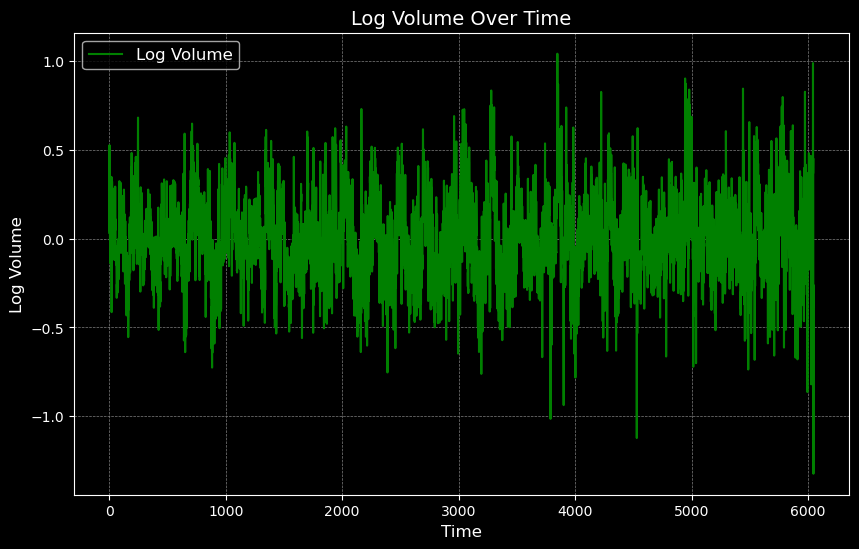

In [15]:
# Step 6: Visualizations

# Visualization 1: Target Variable Over Time
plt.figure(figsize=(10, 6))
plt.style.use('dark_background')
plt.plot(data['log_volume'], color='green', label='Log Volume')
plt.title('Log Volume Over Time', fontsize=14, color='white')
plt.xlabel('Time', fontsize=12, color='white')
plt.ylabel('Log Volume', fontsize=12, color='white')
plt.legend(fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

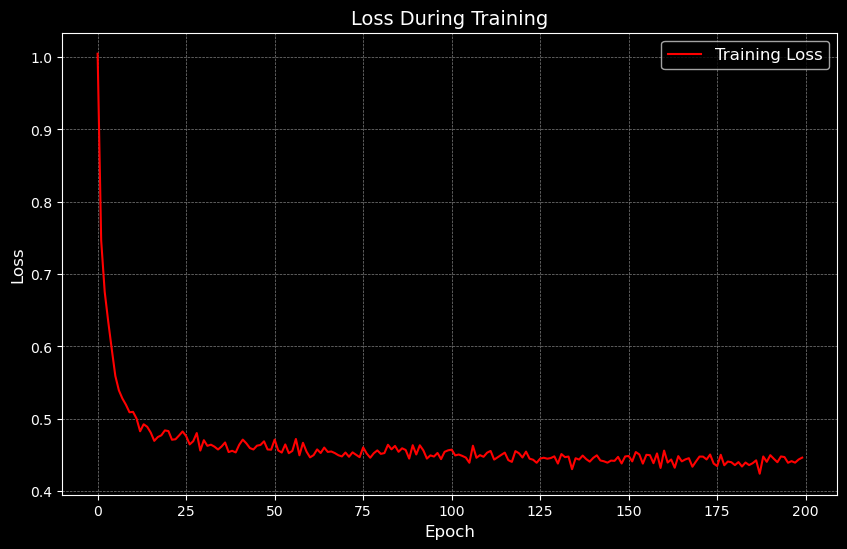

In [16]:
# Visualization 2: Loss During Training
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], color='red', label='Training Loss')
plt.title('Loss During Training', fontsize=14, color='white')
plt.xlabel('Epoch', fontsize=12, color='white')
plt.ylabel('Loss', fontsize=12, color='white')
plt.legend(fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


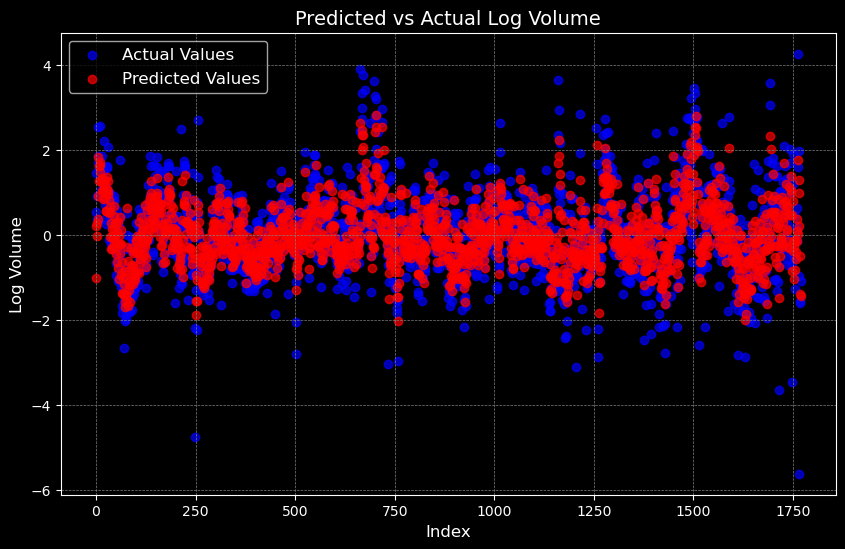

In [18]:
# Visualization 3: Predictions vs Actual Values
Y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(range(len(Y_test)), Y_test, color='blue', label='Actual Values', alpha=0.7)
plt.scatter(range(len(Y_pred)), Y_pred, color='red', label='Predicted Values', alpha=0.7)
plt.title('Predicted vs Actual Log Volume', fontsize=14, color='white')
plt.xlabel('Index', fontsize=12, color='white')
plt.ylabel('Log Volume', fontsize=12, color='white')
plt.legend(fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()
